<a href="https://colab.research.google.com/github/sandhrabijoy/_/blob/master/Pytorch_practice_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np,pandas as pd ,pylab as pl
import h5py,torch
from tensorflow import image as timage
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn as tnn


In [2]:
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class TData(tds):
  def __init__(self,X,y):
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.int32)
  def __getitem__(self,index):
    train_img,train_lbl=self.X[index],self.y[index]
    return train_img,train_lbl
  def __len__(self):
    return self.y.shape[0]

In [4]:
class VGG19(tnn.Module):
  def __init__(self,num_classes):
    super(VGG19,self).__init__()
    self.block1=tnn.Sequential(
        tnn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )
    self.block2=tnn.Sequential(
        tnn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )
    self.block3=tnn.Sequential(
        tnn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )
    self.block4=tnn.Sequential(
        tnn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )
    self.block5=tnn.Sequential(
        tnn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=1),
        tnn.ReLU(),
        tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )

    self.classifier=tnn.Sequential(
        tnn.Linear(512,4096),
        tnn.ReLU(True),
        tnn.Linear(4096,4096),
        tnn.ReLU(True),
        tnn.Linear(4096,num_classes)
    )
    for m in self.modules():
      if isinstance(m,torch.nn.Conv2d):
        m.weight.detach().normal_(0,.05)
        if m.bias is not None:
          m.bias.detach().zero_()
      elif isinstance(m,torch.nn.Linear):
        m.weight.detach().normal_(0,.05)
        m.bias.detach().detach().zero_()
  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.block3(x)
    x=self.block4(x)
    x=self.block5(x)

    logits=self.classifier(x.view(-1,512))
    probs=tnn.functional.softmax(logits,dim=1)
    return logits,probs

In [5]:
def resize_display(x_train, y_train, x_test, y_test, pixels, batch_size=256):
    def resize_batch(x_data, pixels, batch_size):
        """Resize images in batches to reduce memory usage."""
        resized_list = []
        for i in range(0, len(x_data), batch_size):
            batch = x_data[i:i + batch_size]
            batch_resized = np.array(timage.resize(batch, [pixels, pixels]))  # Resize batch
            resized_list.append(batch_resized)
        return np.concatenate(resized_list, axis=0)  # Concatenate all resized batches

    # Resize images in smaller batches to avoid memory overload
    x_train = resize_batch(x_train, pixels, batch_size)
    x_test = resize_batch(x_test, pixels, batch_size)

    # Shuffle train data
    shuffle_ids = np.arange(len(y_train))
    np.random.RandomState(12).shuffle(shuffle_ids)
    x_train, y_train = x_train[shuffle_ids], y_train[shuffle_ids]

    # Shuffle test data
    shuffle_ids = np.arange(len(y_test))
    np.random.RandomState(23).shuffle(shuffle_ids)
    x_test, y_test = x_test[shuffle_ids], y_test[shuffle_ids]

    # Correct the validation split calculation
    n = int(len(x_test) / 2)  # Fixed division issue
    x_valid, y_valid = x_test[:n], y_test[:n]
    x_test, y_test = x_test[n:], y_test[n:]

    # Convert to PyTorch-friendly shape (channels-first)
    x_train = x_train.reshape(-1, 3, pixels, pixels)
    x_valid = x_valid.reshape(-1, 3, pixels, pixels)
    x_test = x_test.reshape(-1, 3, pixels, pixels)

    # Display summary
    df = pd.DataFrame(
        [[x_train.shape, x_valid.shape, x_test.shape],
         [x_train.dtype, x_valid.dtype, x_test.dtype],
         [y_train.shape, y_valid.shape, y_test.shape],
         [y_train.dtype, y_valid.dtype, y_test.dtype]],
        columns=['train', 'valid', 'test'],
        index=['image shape', 'image type', 'label shape', 'label type']
    )
    display(df)

    return [[x_train, x_valid, x_test], [y_train, y_valid, y_test]]

def display_examples(data_loader,pixels):
  for images,labels in data_loader:
    print('Image dimensions:%s'%str(images.shape))
    print('Label dimensions:%s'%str(labels.shape))

    n=np.random.randint(1,50)
    fig=pl.figure(figsize=(11,4))
    for i in range(n,n+5):
      ax=fig.add_subplot(1,5,i-n+1,\
                         xticks=[],yticks=[],title=labels[i].item())
      ax.imshow((images[i]).reshape(pixels,pixels,3))
    break
def model_acc(model,data_loader):
  correct_preds,num_examples=0,0
  for features,targets in data_loader:
    features=features.to(dev)
    targets=targets.to(dev)
    logits,probs=model(features)
    _,pred_labels=torch.max(probs,1)
    num_examples+=targets.size(0)
    correct_preds+=(pred_labels==targets).sum()
  return correct_preds.float()/num_examples*100

In [6]:
@register_line_magic
def train_run(epochs):
  epochs=int(epochs)
  for epoch in range(epochs):
    model.train()
    for batch_ids,(features,targets) in enumerate(train_loader):
      features=features.to(dev);targets=targets.to(dev)
      logits,probs=model(features)
      cost=tnn.functional.cross_entropy(logits,targets.long())
      optimizer.zero_grad();cost.backward()
      optimizer.step()
      if not batch_ids%50:
        print('Epochs:%03d/%03d |Batch:%03d/%03d|Cost:%.4f'%(epoch+1,epochs,batch_ids,len(train)//batch_size,cost))
        model.eval()
        with torch.set_grad_enabled(False):
          print('Epoch:%03d/%03d train acc:%.2f%% valid acc:%.2f%%'%\
                (epoch+1,epochs,
                 model_acc(model,train_loader),
                 model_acc(model,valid_loader)))

@register_line_magic
def print_acc(n):
  if int(n)==1:
    data_loader=\
    [train_loader,valid_loader,test_loader]
  print('Train accuracy:%.4f%%'%\
        (model_acc(model,data_loader[0])))
  print('Valid accuracy:%.4f%%'%\
        (model_acc(model,data_loader[1])))
  print('Test accuracy:%.4f%%'%\
   (model_acc(model,data_loader[2])))

In [7]:
import torch
torch.cuda.empty_cache()

In [8]:
#DATA
pixels = 48
fpath = '/content/drive/MyDrive/'
f = 'CatDogImages.h5'

# Load the file
f = h5py.File(fpath+f , 'r')
keys = list(f.keys())
print(keys)

['test_images', 'test_labels', 'train_images', 'train_labels']


In [9]:
x_test = np.array(f['test_images'])  # Read test images
y_test = np.array(f['test_labels']).reshape(-1)  # Read test labels
x_train = np.array(f['train_images'])  # Read train images
y_train = np.array(f['train_labels']).reshape(-1)  # Read train labels

In [10]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(18610, 128, 128, 3) (18610,)
(4652, 128, 128, 3) (4652,)


In [11]:
[[x_train, x_valid, x_test],
 [y_train, y_valid, y_test]] = resize_display(x_train, y_train, x_test, y_test, pixels)


,train,valid,test
image shape,"(18610, 3, 48, 48)","(2326, 3, 48, 48)","(2326, 3, 48, 48)"
image type,float32,float32,float32
label shape,"(18610,)","(2326,)","(2326,)"
label type,int32,int32,int32


Image dimensions:torch.Size([128, 3, 48, 48])
Label dimensions:torch.Size([128])


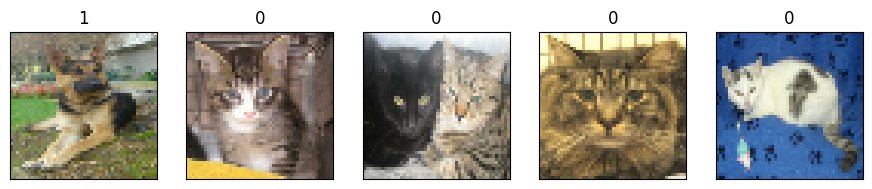

In [12]:
random_seed=1; batch_size=128;
train=TData(x_train,y_train)
valid=TData(x_valid,y_valid)
test=TData(x_test,y_test)
train_loader=tdl(dataset=train,
                  batch_size=batch_size,shuffle=True)
valid_loader=tdl(dataset=valid,
                  batch_size=batch_size,shuffle=True)
test_loader=tdl(dataset=test,
                 batch_size=batch_size,shuffle=False)
display_examples(valid_loader,pixels)


In [13]:
#using VGG19 training
torch.manual_seed(random_seed)
num_classes=2;learning_rate=.001

model=VGG19(num_classes); model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [15]:
%train_run 5 #takes time to run this around 2-3 hours , make sure you know it

Epochs:001/005 |Batch:000/145|Cost:68331.6094
Epoch:001/005 train acc:49.61% valid acc:49.74%
Epochs:001/005 |Batch:050/145|Cost:0.6897
Epoch:001/005 train acc:51.42% valid acc:51.76%
Epochs:001/005 |Batch:100/145|Cost:0.6908
Epoch:001/005 train acc:51.49% valid acc:51.25%
Epochs:002/005 |Batch:000/145|Cost:0.6955
Epoch:002/005 train acc:50.77% valid acc:50.95%
Epochs:002/005 |Batch:050/145|Cost:0.6829
Epoch:002/005 train acc:50.40% valid acc:50.26%
Epochs:002/005 |Batch:100/145|Cost:0.6837
Epoch:002/005 train acc:56.70% valid acc:56.58%
Epochs:003/005 |Batch:000/145|Cost:0.6959
Epoch:003/005 train acc:60.32% valid acc:59.63%
Epochs:003/005 |Batch:050/145|Cost:0.6741
Epoch:003/005 train acc:60.60% valid acc:60.49%
Epochs:003/005 |Batch:100/145|Cost:0.6628
Epoch:003/005 train acc:58.77% valid acc:58.73%
Epochs:004/005 |Batch:000/145|Cost:0.6539
Epoch:004/005 train acc:59.84% valid acc:59.29%
Epochs:004/005 |Batch:050/145|Cost:0.7590
Epoch:004/005 train acc:55.20% valid acc:54.99%
Epochs

In [16]:
%print_acc 1

Train accuracy:53.6378%
Valid accuracy:52.6655%
Test accuracy:51.2468%
